# Statistical Modeling
### Reference:
 1. Book: Johansson [p.471]
 2. Book: Massaron [p.88]

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.plotting.register_matplotlib_converters()
%matplotlib inline
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

Reference:
 1. [SO | Sc. to Num Output and Pretty Printing](https://stackoverflow.com/questions/9777783/suppress-scientific-notation-in-numpy-when-creating-array-from-nested-list)

In [2]:
from pprint import pprint

#This is a little recursive helper function converts all nested ndarrays to python list of lists so that pretty printer knows what to do.

def arrayToList(arr):
    if type(arr) == type(np.array):
        #If the passed type is an ndarray then convert it to a list and
        #recursively convert all nested types
        return arrayToList(arr.tolist())
    else:
        #if item isn't an ndarray leave it as is.
        return arr

#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.8f}'.format}, linewidth=120)

## 1. Statistical Modeling Basics:

- A widely used statistical model is Y = β0 + β1 X + ε, where β0 and β1 are model parameters and ε is normally distributed with zero mean and variance σ2: ε~N(0, σ2). This model is known as simple linear regression if X is a scalar, multiple linear regression if X is a vector, and multivariate linear regression if Y is a vector. 
- Because the residual ε is normally distributed, for all these cases, the model can be fitted to data using ordinary least squares (OLS). 
- Relaxing the condition that the elements in Y, in the case of multivariate linear regression, must be independent and normally distributed with equal variance gives rise to variations of the model that can be solved with methods known as generalized least squares (GLS) and weighted least squares (WLS). 
- All methods for solving statistical models typically have a set of assumptions that one has to be mindful of when applying the models. For standard linear regression, the most important assumption is that the residuals are independent and normally distributed.

### 1.1. Design Matrix:
Once the mathematical form of the model has been established, the next step is often
to construct the so-called design matrices y and X such that the regression problem can
be written in matrix form as y = Xβ + ε, where y is the vector (or matrix) of observations,
β is a vector of coefficients, and ε is the residual (error). The elements Xij of the design
matrix X are the values of the (functions of) explanatory variables corresponding to each
coefficient βj and observation yi. Many solvers for statistical models in statsmodels and
other statistical modeling libraries can take the design matrices X and y as input.
For example, if the observed values are y = [1, 2, 3, 4, 5] with two independent
variables with corresponding values x1 = [6, 7, 8, 9, 10] and x2 = [11, 12, 13, 14, 15], and
if the linear model under consideration is Y = β0 + β1X1 + β2X2 + β3X1X2, then the design
matrix for the right-hand side is X = [1, x1, x2, x1x2]. We can construct this design matrix
using the NumPy vstack function:

In [3]:
y = np.array([1, 2, 3, 4, 5])
x1 = np.array([6, 7, 8, 9, 10])
x2 = np.array([11, 12, 13, 14, 15])
X = np.vstack([np.ones(5), x1, x2, x1*x2]).T
X

array([[      1.00000000,       6.00000000,      11.00000000,      66.00000000],
       [      1.00000000,       7.00000000,      12.00000000,      84.00000000],
       [      1.00000000,       8.00000000,      13.00000000,     104.00000000],
       [      1.00000000,       9.00000000,      14.00000000,     126.00000000],
       [      1.00000000,      10.00000000,      15.00000000,     150.00000000]])

Given the design matrix X and observation vector y, we can solve for the unknown
coefficient vector β, for example, using least square fit:

In [4]:
beta, res, rank, sval = np.linalg.lstsq(X, y)
pprint(arrayToList(beta))

array([     -0.55555556,       1.88888889,      -0.88888889,      -0.00000000])


## 1.2. Patsy
Although constructing the design matrix X was straightforward
in this simple example, it can be tedious for more involved models and if we wish to be
able to easily change how the model is defined. This is where the Patsy library enters
the picture. It offers a convenient (although not necessarily intuitive) formula language
for defining a model and automatically constructing the relevant design matrices.


To construct the design matrix for a Patsy formula, we can use the <code>patsy.dmatrices</code>
function. It takes the formula as a string as the first argument and a dictionary-like object
with data arrays for the response and explanatory variables as the second argument.
The basic syntax for the Patsy formula is <code>"y ~ x1 + x2 + ..."</code>, which means that y
is a linear combination of the explanatory variables x1 and x2 (explicitly including an
intercept coefficient). For a summary of the Patsy formula syntax, see Table 14-1.
As an introductory example, consider again the linear model <code>Y = β0 + β1X1+ β2X2 + β3X1X2</code>
that we used earlier. To define this model with Patsy, we can use the formula <code>y ~ 1 + x1 + x2 + x1*x2</code>.

<img src="assets/patsy.jpg"/>

Note that we leave out coefficients in the model formula, as it is
implicitly assumed that each term in the formula has a model parameter as a coefficient.
In addition to specifying the formula, we also need to create a dictionary data that maps
the variable names to the corresponding data arrays:

In [5]:
data = {"y": y, "x1": x1, "x2": x2}
y, X = patsy.dmatrices("y ~ 1 + x1 + x2 + x1*x2", data)

# The result is two arrays y and X, which are the design matrices for the given data arrays and the specified model formula:
y

DesignMatrix with shape (5, 1)
  y
  1
  2
  3
  4
  5
  Terms:
    'y' (column 0)

In [6]:
# These arrays are of type DesignMatrix, which is a Patsy-supplied subclass of the
# standard NumPy array, which contains additional metadata and an altered printing
# representation.
# help(patsy.design_info.DesignMatrix)

print(f'Type of X: {type(X)}')
X

Type of X: <class 'patsy.design_info.DesignMatrix'>


DesignMatrix with shape (5, 4)
  Intercept  x1  x2  x1:x2
          1   6  11     66
          1   7  12     84
          1   8  13    104
          1   9  14    126
          1  10  15    150
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'x2' (column 2)
    'x1:x2' (column 3)

As a subclass of the NumPy <code>ndarray</code>, the arrays of type <code>DesignMatrix</code> are fully
compatible with code that expects NumPy <code>array</code>s as input. However, we can also
explicitly cast a <code>DesignMatrix</code> instance into an <code>ndarray</code> object using the <code>np.array</code>
function, although this normally should not be necessary.

In [7]:
np.array(X)

array([[      1.00000000,       6.00000000,      11.00000000,      66.00000000],
       [      1.00000000,       7.00000000,      12.00000000,      84.00000000],
       [      1.00000000,       8.00000000,      13.00000000,     104.00000000],
       [      1.00000000,       9.00000000,      14.00000000,     126.00000000],
       [      1.00000000,      10.00000000,      15.00000000,     150.00000000]])

Alternatively, we can set the <code>return_type</code> argument to <code>DataFrame</code>, in which case the <code>patsy.dmatrices</code> function returns design matrices in the form of Pandas <code>DataFrame</code> objects. Also note that since <code>DataFrame</code> objects behave as dictionary-like objects, so we can use data frames to specify the model data as the second argument to the <code>patsy.dmatrices</code> function.

In [8]:
df_data = pd.DataFrame(data)
y, X = patsy.dmatrices("y ~ 1 + x1 + x2 + x1*x2", df_data, return_type="dataframe")
X

,Intercept,x1,x2,x1:x2
0,1.0,6.0,11.0,66.0
1,1.0,7.0,12.0,84.0
2,1.0,8.0,13.0,104.0
3,1.0,9.0,14.0,126.0
4,1.0,10.0,15.0,150.0


### <code>statsmodels.api</code>
With the help of Patsy, we have now automatically created the design matrices
required for solving a statistical model, using, for example, the <code>np.linalg.lstsq</code>
function (as we saw an example earlier), or using one of the many statistical model
solvers provided by the statsmodels library. For example, to perform an ordinary linear
regression (OLS), we can use the class <code>OLS</code> from the <code>statsmodels</code> library instead of using
the lower-level method <code>np.linalg.lstsq</code>. Nearly all classes for statistical models in
statsmodels take the design matrices y and X as the first and second arguments and return a class instance that represents the model. To actually fit the model to the data encoded in the design matrices, we need to invoke the <code>fit</code> method, which returns a result object that contains fitted parameters (among other attributes):

In [9]:
model = sm.OLS(y, X)
result = model.fit()
result.params

Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -1.332268e-15
dtype: float64

### <code>statsmodels.formulas.api</code>
Using the statsmodels formula API (the module that we imported as smf),
we can directly pass the Patsy formula for the model when we create a model instance,
which completely eliminates the need for first creating the design matrices. Instead of
passing y and X as arguments, we then pass the Patsy formula and the dictionary-like
object (e.g., a Pandas data frame) that contains the model data.

In [10]:
model = smf.ols("y ~ 1 + x1 + x2 + x1:x2", df_data)
result = model.fit()
result.params

Intercept   -5.555556e-01
x1           1.888889e+00
x2          -8.888889e-01
x1:x2       -1.332268e-15
dtype: float64

### Reference:
 1. [DefaultDict](https://www.accelebrate.com/blog/using-defaultdict-python)

As a concrete example, consider the following formula and the resulting right-hand
side terms (which we can extract from the <code>design_info</code> attribute using the <code>term_names</code>
attribute):

In [11]:
from collections import defaultdict
data = defaultdict(lambda: np.array([]))
patsy.dmatrices("y ~ a", data=data)[1].design_info.term_names
data

defaultdict(<function __main__.<lambda>()>,
            {'a': array([], dtype=float64), 'y': array([], dtype=float64)})

## 2. Linear Regression

The statsmodels library supports several types of statistical models that are applicable
in varying situations, but nearly all follow the same usage pattern, which makes it easy
to switch between different models. Statistical models in <code>statsmodels</code> are represented
by model classes. These can be initiated given the design matrices for the response and
explanatory variables of a linear model or given a Patsy formula and a data frame (or
another dictionary-like object). The basic workflow when setting up and analyzing a
statistical model with <code>statsmodels</code> includes the following steps:

#### 1. Create Model Instance
Create an instance of a model class, for example, using <code>model = sm.MODEL(y, X)</code> or <code>model = smf.model(formula, data)</code>, where <code>MODEL</code> and <code>model</code> are the name of a particular model, such as <code>OLS, GLS, Logit</code> etc. Here the convention is that uppercase names are used for classes that take design matrices as arguments and lowercase names for classes that take Patsy formulas and dataframes as arguments.
    
#### 2. Fit Data to Model
Creating a model instance does not perform any computations. To
    fit the model to the data, we must invoke the <code>fit</code> method, <code>result =
    model.fit()</code>, which performs the fit and returns a result object that
    has methods and attributes for further analysis.
    
#### 3. Statistical Summary
Print summary statistics for the result object returned by the
   <code>fit</code> method. The result object varies in content slightly for each
    statistical model, but most models implement the method
    summary, which produces a summary text that describes the result
    of the fit, including several types of statistics that can be useful
    for judging if the statistical model successfully explains the data.
    Viewing the output from the summary method is usually a good
    starting point when analyzing the result of a fitting process.
   
#### 4. Post - processing (Parameters, Residual, Fitted Values, Prediction)
Post-process the model fit results: in addition to the summary
   method, the result object also contains methods and attributes
    for obtaining the fitted parameters (<code>params</code>), the residual for the
    model and the data (<code>resid</code>), the fitted values (<code>fittedvalues</code>), and a
    method for predicting the value of the response variables for new
    independent variables (<code>predict</code>).
    
#### 5. Visualization of the Model
Finally, it may be useful to visualize the result of the fitting, for
   example, with the <code>Matplotlib</code> and <code>Seaborn</code> graphics libraries,
    of using some of the many graphing routines that are directly
    included in the <code>statsmodels</code> library (see the statsmodels.
    graphics module).
    
## 2.1. Statistical Linear Regression: Creating Model Instance   

To demonstrate this workflow with a simple example, in the following we consider
fitting a model to generate data whose true value is <code>y = 1 + 2.x1 + 3.x2 + 4.x1.x2</code>. We begin with
storing the data in a Pandas data frame object:

In [12]:
N = 100
x1 = np.random.randn(N)
x2 = np.random.randn(N)
data = pd.DataFrame({"x1": x1, "x2": x2})
data.head(3)

,x1,x2
0,-0.052805,-1.345321
1,-0.453226,-1.945994
2,0.833825,0.117000


In [13]:
def y_true(x1, x2):
    return 1 + 2 * x1 + 3 * x2 + 4 * x1 * x2

data["y_true"] = y_true(x1, x2)
data.head(3).round(3)

,x1,x2,y_true
0,-0.053,-1.345,-2.857
1,-0.453,-1.946,-2.217
2,0.834,0.117,3.409


Here we have stored the true value of y in the <code>y_true</code> column in the <code>DataFrame</code> object
<code>data</code>. We simulate a noisy observation of y by adding a normal distributed noise to the
true values and store the result in the y column:

In [14]:
e = 4* np.random.randn(N)
data["y"] = data["y_true"] + e
print(data.shape)
data.head(3).round(3)

(100, 4)


,x1,x2,y_true,y
0,-0.053,-1.345,-2.857,-7.407
1,-0.453,-1.946,-2.217,-0.977
2,0.834,0.117,3.409,-2.289


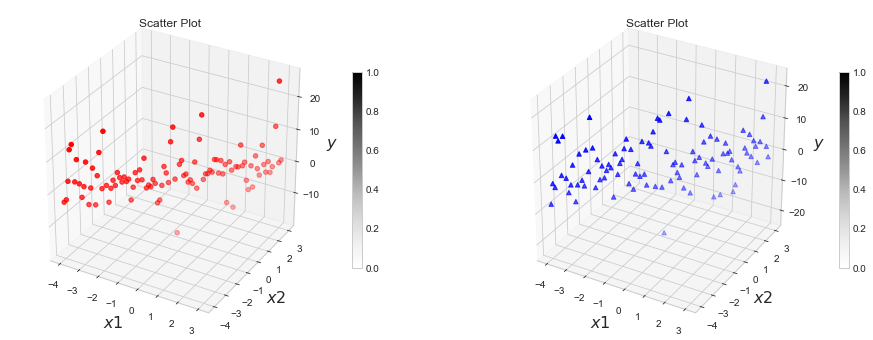

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': '3d'})

def title_and_labels(ax, title):
    ax.set_title(title)
    ax.set_xlabel("$x1$", fontsize=16)
    ax.set_ylabel("$x2$", fontsize=16)
    ax.set_zlabel("$y$", fontsize=16)

x = y = np.linspace(-4, 3, 100)
X, Y = np.meshgrid(x, y)

# Z = 1 + 2 * x1 + 3 * x2 + 4 * x1 * x2
Z1 = data['y_true']
Z2 = data['y']

norm = mpl.colors.Normalize(-abs(Z1).max(), abs(Z1).max())

p = ax[0].scatter(x, y, Z1, c='r', marker='o')

cb = fig.colorbar(p, ax=ax[0], shrink=0.6) 

title_and_labels(ax[0], "Scatter Plot")

p = ax[1].scatter(x, y, Z2, c='b', marker='^')

cb = fig.colorbar(p, ax=ax[1], shrink=0.6) 

title_and_labels(ax[1], "Scatter Plot")

## 2.2 Fit Model

The simplest possible model we can start with is the
linear model <code>Y = β0 + β1x1 + β2x2</code>, which we can define with the Patsy formula <code>y ~ x1 + x2</code>.
Since the response variable is continuous, it is a good starting point to fit the model to
the data using ordinary linear squares, for which we can use the <code>smf.ols</code> class.

In [16]:
model = smf.ols("y ~ x1 + x2", data)
result = model.fit()

Remember that ordinary least square regression assumes that the residuals of the
fitted model and the data are normally distributed. However, before analyzing the
data, we might not know if this condition is satisfied or not. Nonetheless, we can start
by fitting the data to the model and investigate the distribution of the residual using
graphical methods and statistical tests (with the null hypothesis that the residuals are
indeed normally distributed). 

## 2.3 Summary

A lot of useful information, including several types of test
statistics, can be displayed using the <code>summary</code> method:

In [17]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     38.40
Date:                Wed, 12 Feb 2020   Prob (F-statistic):           5.20e-13
Time:                        15:09:27   Log-Likelihood:                -312.86
No. Observations:                 100   AIC:                             631.7
Df Residuals:                      97   BIC:                             639.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8745      0.574      1.524      0.131      -0.264       2.013
x1             3.9205      0.556      7.053      0.000       2.817       5.024
x2             3.1969      0.596      5.368      0.000       2.015       4.379
==============================================================================
Omnibus:                        1.663   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.435   Jarque-Bera (JB):                1.498
Skew:                          -0.299   Prob(JB):                        0.473
Kurtosis:                       2.944   Cond. No.                         1.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2.4 Post Processing

The output produced by the summary method is rather verbose, and a detailed
description of all the information provided by this method is beyond the scope of
this treatment. Instead, here we only focus on a few key indicators. 


### 2.4.1 $R^{2}$
To begin with, the $R^{2}$ value is a statistic that indicates how well the model fits the data. It can take
values between 0 and 1, where an $R^{2}$ statistic of 1 corresponds to a perfect fit.
The $R^{2}$ value of 0.380 reported in the preceding <code>summary</code> method is rather poor,
and it indicates that we need to refine our model (which is expected, since we left out
the interaction term <code>x1 ∙ x2</code>). We can also explicitly access the $R^{2}$ statistic from the
result object using the <code>rsquared</code> attribute.

In [18]:
result.rsquared

0.44189628167431116